In [26]:
import pandas as pd

In [27]:
import os
import glob

def get_all_csv_files(directory):
    # Join the directory path and the pattern for .csv files
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    
    return csv_files





In [28]:

# Example usage:
directory_path = '../data/'
csv_files = get_all_csv_files(directory_path)[:2]
count = 0
total = len(csv_files)
marker = 10
for file in csv_files:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    data = pd.read_csv(file)
    data.dropna(inplace=True)
    data = data.reset_index()
    if not data.empty:
        index = data['DATE (YYYY-MM-DDTHH:MI:SSZ)'].unique()
        float_number = data['PLATFORM_CODE'].iloc[0]
        
        agg_data = {
            'float_number': []
            ,'date':[]
            ,'latitude':[]
            ,'longitude':[]
            ,'q0_psal':[]
            ,'q1_psal':[]
            ,'q2_psal':[]
            ,'q3_psal':[]
            ,'q4_psal':[]
            ,'q0_temp':[]
            ,'q1_temp':[]
            ,'q2_temp':[]
            ,'q3_temp':[]
            ,'q4_temp':[]
        }

        if 'PSAL (psu)' in data.columns and 'TEMP (degree_Celsius)' in data.columns:
            for i in index:
                subset = data[data['DATE (YYYY-MM-DDTHH:MI:SSZ)']==i]
                agg_data['float_number'].append(float_number)
                agg_data['date'].append(i)
                agg_data['latitude'].append(subset['LATITUDE (degree_north)'].iloc[0])
                agg_data['longitude'].append(subset['LONGITUDE (degree_east)'].iloc[0])
                q0 = min(subset['PRES (decibar)'])
                q1 = min(subset['PRES (decibar)'], key=lambda x:abs(x-500))
                q2 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1000))
                q3 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1500))
                q4 = max(subset['PRES (decibar)'])
                agg_data['q0_psal'].append(subset[subset['PRES (decibar)']==q0]['PSAL (psu)'].iloc[0])
                agg_data['q1_psal'].append(subset[subset['PRES (decibar)']==q1]['PSAL (psu)'].iloc[0])
                agg_data['q2_psal'].append(subset[subset['PRES (decibar)']==q2]['PSAL (psu)'].iloc[0])
                agg_data['q3_psal'].append(subset[subset['PRES (decibar)']==q3]['PSAL (psu)'].iloc[0])
                agg_data['q4_psal'].append(subset[subset['PRES (decibar)']==q4]['PSAL (psu)'].iloc[0])
                agg_data['q0_temp'].append(subset[subset['PRES (decibar)']==q0]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q1_temp'].append(subset[subset['PRES (decibar)']==q1]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q2_temp'].append(subset[subset['PRES (decibar)']==q2]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q3_temp'].append(subset[subset['PRES (decibar)']==q3]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q4_temp'].append(subset[subset['PRES (decibar)']==q4]['TEMP (degree_Celsius)'].iloc[0])
            agg_data = pd.DataFrame(agg_data)
            agg_data['date'] = pd.to_datetime(agg_data['date'])
            agg_data['date'] = agg_data['date'].dt.strftime('%Y-%m-%d') 
            
            #all_data = pd.concat([agg_data, all_data])
            




percent done: % 50.0


KeyError: 'DATE (YYYY-MM-DDTHH:MI:SSZ)'

In [ ]:
all_data.to_csv('all_ocean_data.csv', index=False)

In [29]:
import pandas as pd
all_data = pd.read_csv('all_ocean_data.csv')

In [3]:
pd.set_option('display.min_rows', 70)
pd.set_option('display.max_columns', None)

In [30]:
sorted_data = all_data.sort_values(['date','float_number'], ascending=[True, True])

In [33]:
sorted_data.duplicated().sum()

406319

In [34]:
len(sorted_data)

1087838

In [35]:
undup = sorted_data.drop_duplicates()
undup.shape

(681519, 14)

In [38]:
undup.to_csv('all_ocean_data.csv', index=False)

In [ ]:
for date in undup['date'].unique():

    print(undup[undup['date']==date][['date', 'latitude','longitude']])

In [23]:
import datetime as dt
undup['date'] = pd.to_datetime(undup['date'])
undup = undup[undup['date'].dt.year==2006]

C:\Users\Jon\AppData\Local\Temp\ipykernel_39148\3366570401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undup['date'] = pd.to_datetime(undup['date'])


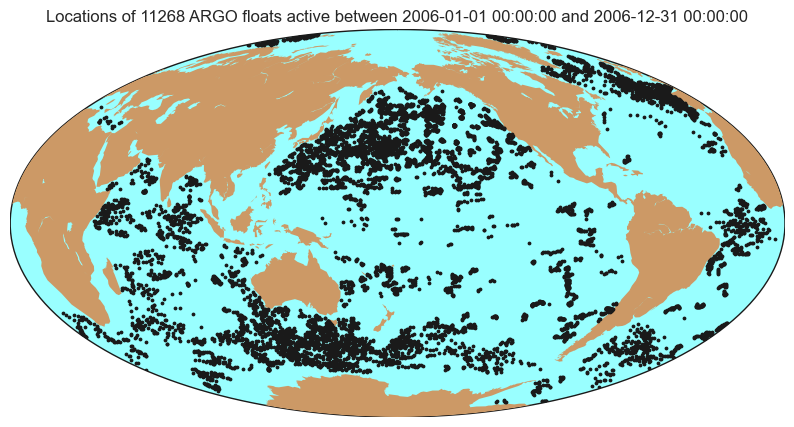

In [24]:
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
# data downloaded from the form at
# http://coastwatch.pfeg.noaa.gov/erddap/tabledap/apdrcArgoAll.html

lats = undup['latitude']
lons = undup['longitude']
time = undup['date']  # seconds since epoch
times = time
t1 = times.min(); t2 = times.max()
date1 = t1
date2 = t2

# draw map with markers for float locations
m = Basemap(projection='hammer',lon_0=180)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats active between %s and %s' %\
        (len(lats),date1,date2),fontsize=12)
plt.show()

## Making data for animated map

In [70]:
import pandas as pd
import numpy as np

def generate_interpolated_rows(df):
    # Sort the dataframe by 'id' and 'date' for each id
    df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is a datetime object
    df = df.sort_values(by=['float_number', 'date'])

    new_rows = []

    for idx in range(len(df) - 1):
        current_row = df.iloc[idx]
        next_row = df.iloc[idx + 1]

        # Check if it's the same 'id'
        if current_row['float_number'] == next_row['float_number']:
            # Calculate the number of days between the two dates
            days_diff = (next_row['date'] - current_row['date']).days
            
            if days_diff > 1 and days_diff<31:
                # Generate evenly spaced latitudes, longitudes, and dates
                latitudes = np.linspace(current_row['latitude'], next_row['latitude'], round((days_diff + 1)/2))
                longitudes = np.linspace(current_row['longitude'], next_row['longitude'], round((days_diff + 1)/2))
                dates = pd.date_range(current_row['date'], next_row['date'], periods=round((days_diff + 1)/2))
                
                # Add the interpolated rows (excluding the first one because it's already in df)
                for i in range(1, round(days_diff/2)):
                    new_row = {
                        'float_number': current_row['float_number'],
                        'latitude': latitudes[i],
                        'longitude': longitudes[i],
                        'date': dates[i]
                    }
                    new_rows.append(new_row)

    # Convert the new_rows list into a DataFrame and append to the original DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_rows_df]).sort_values(by=['float_number', 'date']).reset_index(drop=True)
    
    return df



In [71]:
all_ocean = pd.read_csv('all_ocean_data.csv')[['float_number','date','longitude','latitude']]

In [72]:
id_index = all_ocean['float_number'].unique()

In [73]:
all_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id_index[0]])
all_df.to_csv('data_for_map.csv', index=False)

In [74]:
all_df = pd.read_csv('data_for_map.csv')
all_df

,float_number,date,longitude,latitude


In [11]:
import warnings
warnings.simplefilter('ignore')

In [75]:
import warnings
# Helpful for keeping the output clear
warnings.simplefilter('ignore')
all_df = pd.read_csv('data_for_map.csv')
count = 0
total = len(id_index)
marker = 0


for id in id_index:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    new_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id])
    all_df = pd.concat([new_df, all_df])
    # all_df.to_csv('data_for_map.csv', index=False) This significantly slowed down the process by like a factor of 1000
    # And I think it was not correctly saving it either
    


percent done: % 0.008768853034023149
percent done: % 10.005261311820414
percent done: % 20.001753770606804
percent done: % 30.00701508242722
percent done: % 40.00350754121361
percent done: % 50.0
percent done: % 60.00526131182041
percent done: % 70.00175377060681
percent done: % 80.00701508242722
percent done: % 90.00350754121361
percent done: % 100.0


In [80]:
all_df.to_csv('data_for_map.csv', index=False)

In [58]:
len(id_index)

9534

In [61]:
data_map = pd.read_csv('data_for_map.csv')

In [62]:
new_index = data_map['float_number'].unique()

In [63]:
len(new_index)

11404

In [55]:
id_index = [item for item in id_index if item not in new_index]

In [16]:
all_ocean = pd.read_csv('data_for_map.csv')

In [20]:
all_ocean

,float_number,date,longitude,latitude
0,1900083,2001-08-26 00:00:00.000000000,34.71100,-29.67400
1,1900083,2001-08-26 00:00:00.000000000,34.71100,-29.67400
2,1900083,2001-08-26 00:00:00.000000000,34.71100,-29.67400
3,1900083,2001-08-28 00:00:00.000000000,34.68900,-29.59380
4,1900083,2001-08-30 00:00:00.000000000,34.66700,-29.51360
...,...,...,...,...
4480394,7902201,2024-09-08 00:00:00.000000000,60.88182,-2.82954
4480395,7902201,2024-09-10 00:00:00.000000000,60.92164,-2.81708
4480396,7902201,2024-09-12 00:00:00.000000000,60.96146,-2.80462
4480397,7902201,2024-09-14 00:00:00.000000000,61.00128,-2.79216


In [21]:
all_ocean[all_ocean['date'].str[:4]=='2023']

,float_number,date,longitude,latitude
232260,1901604,2023-02-06 00:00:00.000000000,11.055000,-30.676000
232261,1901604,2023-02-06 00:00:00.000000000,11.055000,-30.676000
232262,1901604,2023-02-06 00:00:00.000000000,11.055000,-30.676000
291066,1901740,2023-01-02 18:40:00.000000000,76.341089,-31.248722
291067,1901740,2023-01-05 00:00:00.000000000,76.295700,-31.174600
...,...,...,...,...
4479414,7901128,2023-12-12 08:00:00.000000000,66.405557,19.283333
4479415,7901128,2023-12-14 13:20:00.000000000,66.409261,19.255556
4479416,7901128,2023-12-16 18:40:00.000000000,66.412966,19.227778
4479417,7901128,2023-12-19 00:00:00.000000000,66.416670,19.200000


In [22]:
subset = pd.concat([all_ocean[all_ocean['date'].str[:4]=='2022'],all_ocean[all_ocean['date'].str[:4]=='2023']])

In [23]:
subset.to_csv('data_for_map_2023.csv')

## Make data for lstm

In [78]:
id_index = all_ocean['float_number'].unique()

In [21]:
import numpy as np
all_ocean = pd.read_csv('all_ocean_data.csv')
all_ocean['date'] = pd.to_datetime(all_ocean['date'])  # Ensure 'date' is a datetime object
all_ocean = all_ocean.sort_values(by=['float_number', 'date'], ascending=True)
id_index = all_ocean['float_number'].unique()
last_index = id_index[0]
recent = all_ocean[all_ocean['float_number']==last_index]
recent['distance'] = 0
lstm_df = recent

count = 0
total = len(id_index)
marker = 0


for _ in range(len(id_index)):
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    last_lat, last_long = recent['latitude'].iloc[-1], recent['longitude'].iloc[-1]
    id_index = [item for item in id_index if item != last_index]
    best = np.inf
    for id in id_index:
        next_lat, next_long = all_ocean[all_ocean['float_number']==id]['latitude'].iloc[0], all_ocean[all_ocean['float_number']==id]['longitude'].iloc[0]
        distance = (((next_lat-last_lat)**2) + ((next_long - last_long)**2))**0.5
        if distance < best:
            last_index = id
            best = distance
    recent = all_ocean[all_ocean['float_number']==last_index] 
    recent['distance'] = best
    lstm_df = pd.concat([lstm_df, recent])




percent done: % 0.008768853034023149
percent done: % 10.005261311820414
percent done: % 20.001753770606804
percent done: % 30.00701508242722
percent done: % 40.00350754121361
percent done: % 50.0
percent done: % 60.00526131182041
percent done: % 70.00175377060681
percent done: % 80.00701508242722
percent done: % 90.00350754121361
percent done: % 100.0


In [22]:
lstm_df.to_csv('lstm_data.csv', index=False)

In [3]:
lstm_df = pd.read_csv('lstm_data.csv')

In [5]:
lstm_for_map = pd.concat([
    lstm_df.iloc[:5000],
    lstm_df.iloc[300000:305000],
    lstm_df.iloc[500000:505000],
    lstm_df.iloc[650000:655000],

])

In [7]:
lstm_for_map.to_csv('lstm_for_map.csv')

In [8]:
index = lstm_for_map.index.tolist()

In [15]:
lstm_for_map.loc[index[15001:15005]]

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
650001,656983,1901612,2015-11-01,-58.4870,135.0110,33.844,34.484,34.686,34.740,34.735,1.399,2.430,2.267,1.907,1.435,32.632727
650002,1073,7900900,2020-02-22,-59.9406,139.9241,33.817,34.650,34.730,34.740,34.723,3.558,2.178,1.864,1.525,1.132,5.123622
650003,1074,7900900,2020-03-03,-60.1830,140.4060,33.814,34.651,34.736,34.739,34.723,3.457,2.148,1.872,1.489,1.110,5.123622
650004,1075,7900900,2020-03-13,-60.5501,140.0715,33.815,34.640,34.731,34.741,34.724,3.514,2.173,1.882,1.523,1.125,5.123622


## LSTM Model

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('lstm_data.csv')

In [3]:
df

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
0,527182,29034,2000-11-09,29.541,144.013,34.637,34.545,34.216,34.472,34.585,26.977,14.051,4.273,2.675,2.040,0.0
1,527183,29034,2000-12-09,28.980,143.237,34.718,34.475,34.270,34.473,34.583,24.441,13.197,4.491,2.730,2.038,0.0
2,527184,29034,2000-12-19,28.880,143.215,34.658,34.522,34.257,34.485,34.591,23.377,13.794,4.709,2.609,2.005,0.0
3,527185,29034,2000-12-29,28.709,143.096,34.685,34.502,34.293,34.487,34.590,22.036,13.525,4.520,2.637,2.029,0.0
4,527186,29034,2001-01-08,28.504,143.012,34.762,34.447,34.296,34.493,34.596,21.855,12.802,4.298,2.591,1.986,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681535,420272,4900946,2013-06-09,45.865,-175.566,33.165,34.102,34.367,34.501,34.578,8.213,3.900,2.868,2.289,1.942,inf
681536,420273,4900946,2013-07-19,46.202,-175.465,32.923,34.073,34.375,34.498,34.573,11.690,3.750,2.887,2.312,1.961,inf
681537,420274,4900946,2013-08-08,46.298,-175.172,32.876,34.086,34.367,34.499,34.575,12.810,3.766,2.874,2.306,1.956,inf
681538,420275,4900946,2013-09-17,46.102,-173.380,32.888,34.059,34.369,34.496,34.578,12.274,3.831,2.914,2.320,1.946,inf


<Axes: >

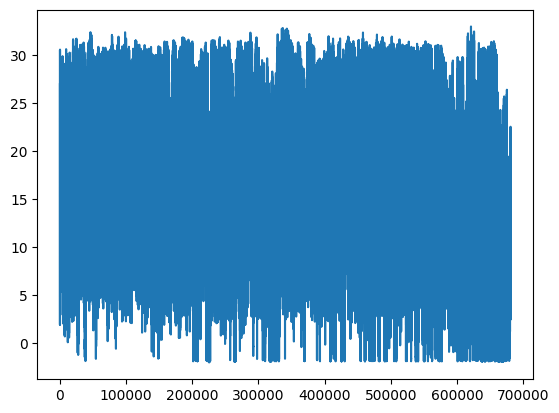

In [4]:
temp = df['q0_temp']
temp.plot()

<Axes: >

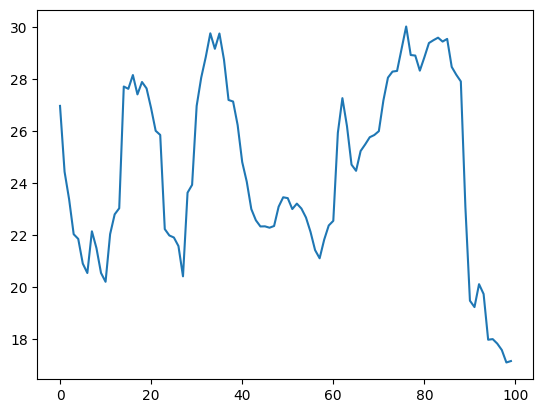

In [5]:
temp[:100].plot()

### Full model

### Start of 2 prediction variables

In [9]:
df = df[:300000]

In [10]:
df

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
0,527182,29034,2000-11-09,29.541,144.013,34.637,34.545,34.216,34.472,34.585,26.977,14.051,4.273,2.675,2.040,0.000000
1,527183,29034,2000-12-09,28.980,143.237,34.718,34.475,34.270,34.473,34.583,24.441,13.197,4.491,2.730,2.038,0.000000
2,527184,29034,2000-12-19,28.880,143.215,34.658,34.522,34.257,34.485,34.591,23.377,13.794,4.709,2.609,2.005,0.000000
3,527185,29034,2000-12-29,28.709,143.096,34.685,34.502,34.293,34.487,34.590,22.036,13.525,4.520,2.637,2.029,0.000000
4,527186,29034,2001-01-08,28.504,143.012,34.762,34.447,34.296,34.493,34.596,21.855,12.802,4.298,2.591,1.986,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,284513,5901709,2007-06-30,-34.375,95.926,35.054,34.789,34.364,34.540,34.674,14.163,10.087,5.176,3.181,2.550,2.038284
299996,284514,5901709,2007-07-10,-34.192,95.346,35.257,34.784,34.366,34.537,34.677,14.469,10.078,5.364,3.285,2.545,2.038284
299997,284515,5901709,2007-07-20,-33.923,94.950,35.254,34.787,34.366,34.541,34.678,14.332,10.087,5.314,3.201,2.531,2.038284
299998,284516,5901709,2007-07-30,-33.662,94.795,35.230,34.797,34.369,34.555,34.676,13.652,10.128,5.302,3.240,2.548,2.038284


In [11]:
temp_df = df.drop(['Unnamed: 0','float_number','date','distance'], axis=1)

In [12]:
test_size = round(0.1*len(temp_df))
test_df = temp_df[len(temp_df)-test_size:]
temp_df = temp_df[:len(temp_df)-test_size]

In [13]:
temp_df

,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
0,29.5410,144.0130,34.6370,34.5450,34.2160,34.4720,34.5850,26.9770,14.0510,4.2730,2.6750,2.0400
1,28.9800,143.2370,34.7180,34.4750,34.2700,34.4730,34.5830,24.4410,13.1970,4.4910,2.7300,2.0380
2,28.8800,143.2150,34.6580,34.5220,34.2570,34.4850,34.5910,23.3770,13.7940,4.7090,2.6090,2.0050
3,28.7090,143.0960,34.6850,34.5020,34.2930,34.4870,34.5900,22.0360,13.5250,4.5200,2.6370,2.0290
4,28.5040,143.0120,34.7620,34.4470,34.2960,34.4930,34.5960,21.8550,12.8020,4.2980,2.5910,1.9860
...,...,...,...,...,...,...,...,...,...,...,...,...
269995,15.2961,129.2307,34.4387,34.2791,34.5355,34.5847,34.6318,29.4014,7.6298,4.2752,2.9344,2.1502
269996,15.3237,129.1482,34.0643,34.2325,34.5318,34.5887,34.6311,29.6414,7.9389,4.3218,2.8649,2.1365
269997,15.3823,129.0295,34.1662,34.2478,34.5299,34.5849,34.6319,30.0599,7.9914,4.3825,2.9369,2.1412
269998,15.4429,128.9046,34.1763,34.2790,34.5295,34.5817,34.6311,29.9369,8.1831,4.3774,3.0579,2.1635


In [14]:
from sklearn.preprocessing import StandardScaler

scaler_pos = StandardScaler()
scaler = StandardScaler()

# Fit and transform the data to standardize it
# This returns a NumPy array, so we need to convert it back to a DataFrame
scaled_pos = scaler_pos.fit(temp_df[['latitude','longitude']])
scaled = scaler.fit(temp_df.drop(['latitude','longitude'], axis=1))
scaled_pos = scaler_pos.transform(temp_df[['latitude','longitude']])
scaled = scaler.transform(temp_df.drop(['latitude','longitude'], axis=1))
df_scaled_pos = pd.DataFrame(scaled_pos, columns=['latitude','longitude'])
df_scaled = pd.DataFrame(scaled, columns=temp_df.drop(['latitude','longitude'], axis=1).columns)
df_scaled_pos[df_scaled.columns] = scaled
temp_df = df_scaled_pos

In [57]:
from sklearn.preprocessing import StandardScaler



# Fit and transform the data to standardize it
# This returns a NumPy array, so we need to convert it back to a DataFrame
scaled_pos = scaler_pos.transform(test_df[['latitude','longitude']])
scaled = scaler.transform(test_df.drop(['latitude','longitude'], axis=1))
df_scaled_pos = pd.DataFrame(scaled_pos, columns=['latitude','longitude'])
df_scaled = pd.DataFrame(scaled, columns=temp_df.drop(['latitude','longitude'], axis=1).columns)
df_scaled_pos[df_scaled.columns] = scaled
test_df = df_scaled_pos

In [58]:
temp_df[5:]

,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
5,0.443699,1.163484,0.020721,-0.151774,-0.931166,-0.814967,-0.676874,0.022666,1.446366,-0.044951,-0.443493,-0.476923
6,0.440914,1.162271,-0.011797,-0.195145,-0.856952,-0.723773,-0.698677,-0.022454,1.359879,-0.246281,-0.545998,-0.449165
7,0.445893,1.163800,0.121525,-0.241986,-1.099834,-0.871420,-0.736831,0.177717,1.360467,-0.183446,-0.378410,-0.443960
8,0.451707,1.160759,0.126403,-0.096259,-1.197661,-0.823652,-0.687775,0.096951,1.709652,-0.074445,-0.427222,-0.494271
9,0.452890,1.158099,0.085756,-0.162183,-1.093087,-0.875763,-0.676874,-0.022205,1.532265,-0.182805,-0.383291,-0.509017
...,...,...,...,...,...,...,...,...,...,...,...,...
269995,-0.009753,1.055069,-0.274620,-0.498569,-0.065900,-0.390699,-0.481741,1.081778,-0.165769,-0.064699,-0.200734,-0.319745
269996,-0.008793,1.054401,-0.578984,-0.579413,-0.078381,-0.373329,-0.485557,1.111692,-0.074840,-0.034820,-0.257275,-0.331628
269997,-0.006752,1.053442,-0.496146,-0.552870,-0.084791,-0.389831,-0.481196,1.163853,-0.059396,0.004099,-0.198700,-0.327551
269998,-0.004643,1.052432,-0.487935,-0.498743,-0.086140,-0.403727,-0.485557,1.148523,-0.003002,0.000829,-0.100263,-0.308208


In [59]:
temp_df.columns

Index(['latitude', 'longitude', 'q0_psal', 'q1_psal', 'q2_psal', 'q3_psal',
       'q4_psal', 'q0_temp', 'q1_temp', 'q2_temp', 'q3_temp', 'q4_temp'],
      dtype='object')

In [60]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [61]:
temp_df

,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
0,0.486173,1.174603,-0.113414,-0.037274,-1.143687,-0.880105,-0.736831,0.779602,1.723184,-0.066110,-0.411765,-0.415335
1,0.466642,1.168328,-0.047566,-0.158713,-0.961526,-0.875763,-0.747733,0.463516,1.471959,0.073667,-0.367020,-0.417070
2,0.463161,1.168150,-0.096343,-0.077175,-1.005380,-0.823652,-0.704127,0.330899,1.647581,0.213445,-0.465458,-0.445695
3,0.457207,1.167188,-0.074393,-0.111872,-0.883939,-0.814967,-0.709578,0.163758,1.568448,0.092262,-0.442679,-0.424877
4,0.450070,1.166509,-0.011797,-0.207289,-0.873819,-0.788912,-0.676874,0.141198,1.355760,-0.050080,-0.480102,-0.462176
...,...,...,...,...,...,...,...,...,...,...,...,...
269995,-0.009753,1.055069,-0.274620,-0.498569,-0.065900,-0.390699,-0.481741,1.081778,-0.165769,-0.064699,-0.200734,-0.319745
269996,-0.008793,1.054401,-0.578984,-0.579413,-0.078381,-0.373329,-0.485557,1.111692,-0.074840,-0.034820,-0.257275,-0.331628
269997,-0.006752,1.053442,-0.496146,-0.552870,-0.084791,-0.389831,-0.481196,1.163853,-0.059396,0.004099,-0.198700,-0.327551
269998,-0.004643,1.052432,-0.487935,-0.498743,-0.086140,-0.403727,-0.485557,1.148523,-0.003002,0.000829,-0.100263,-0.308208


In [62]:
X3, y3 = df_to_X_y3(temp_df)
X3.shape, y3.shape
X3_test, y3_test = df_to_X_y3(test_df)


In [63]:
train_size = round(0.8*(len(X3)))

X_3train, y_3train = X3[:train_size], y3[:train_size]
X_3val, y_3val = X3[train_size:], y3[train_size:]
X_3train.shape, y_3train.shape, X_3val.shape, y_3val.shape, X3_test.shape, y3_test.shape

((215994, 7, 12),
 (215994, 2),
 (53999, 7, 12),
 (53999, 2),
 (29993, 7, 12),
 (29993, 2))

In [66]:
model5 = Sequential()
model5.add(InputLayer((7, 12)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19712     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 20250 (79.10 KB)
Trainable params: 20250 (79.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [69]:
model5.fit(X_3train, y_3train, validation_data=(X_3val, y_3val), epochs=10, callbacks=[cp5])

Epoch 1/10
6735/6750 [============================>.] - ETA: 0s - loss: 0.0371 - root_mean_squared_error: 0.1926INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 38s 5ms/step - loss: 0.0370 - root_mean_squared_error: 0.1925 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 2/10
6749/6750 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1035INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 37s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 3/10
6744/6750 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1010INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 36s 5ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 4/10
6737/6750 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.1003INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 41s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 5/10
6747/6750 [============================>.] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0998INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 39s 6ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 6/10
6748/6750 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0995INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 37s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 7/10
6741/6750 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0993INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 39s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 8/10
6750/6750 [==============================] - 40s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 9/10
6740/6750 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0989INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 42s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 10/10
6750/6750 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0987INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


6750/6750 [==============================] - 74s 11ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955


In [72]:
import matplotlib.pyplot as plt
def plot_predictions2(model, X, y, start=0, end=100):
  df_predictions = pd.DataFrame(model.predict(X))


  predictions = scaler_pos.inverse_transform(df_predictions)
  lat_preds, long_preds = predictions[:, 0], predictions[:, 1]
  
  y = scaler_pos.inverse_transform(pd.DataFrame(y))
  lat_actuals, long_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Longitude Predictions': long_preds,
                          'Longitude Actuals':long_actuals,
                          'Latitude Predictions': lat_preds,
                          'Latitude Actuals': lat_actuals
                          })
  plt.plot(df['Longitude Predictions'][start:end], label='Longitude Predictions')
  plt.plot(df['Longitude Actuals'][start:end], label='Longitude Actuals')
  plt.plot(df['Latitude Predictions'][start:end], label='Latitude Predictions')
  plt.plot(df['Latitude Actuals'][start:end], label='Latitude Actuals')
  plt.legend(bbox_to_anchor=(0.75, 1.15), ncol=2)
  return df

938/938 [==============================] - 2s 2ms/step


,Longitude Predictions,Longitude Actuals,Latitude Predictions,Latitude Actuals
0,127.834206,127.7722,15.537218,15.5368
1,127.685646,127.5766,15.604706,15.4691
2,127.561714,127.3890,15.566455,15.3842
3,127.284569,127.2234,15.473358,15.2776
4,127.019249,127.1056,15.405187,15.1134
...,...,...,...,...
29988,99.921722,95.9260,-35.133499,-34.3750
29989,99.667786,95.3460,-34.853329,-34.1920
29990,98.422531,94.9500,-34.527752,-33.9230
29991,98.596375,94.7950,-34.286335,-33.6620


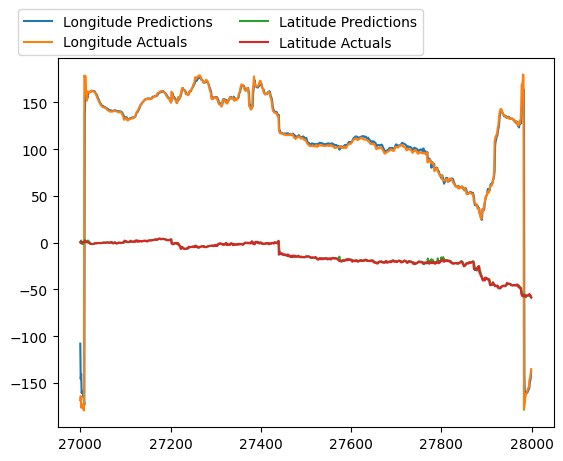

In [73]:

plot_predictions2(model5, X3_test, y3_test, 27000, 28000)

## Make Prediction Data for LSTM Map

In [74]:
df = pd.read_csv('pages/lstm_for_map.csv')

In [75]:
df.columns

Index(['float_number', 'date', 'latitude', 'longitude', 'q0_psal', 'q1_psal',
       'q2_psal', 'q3_psal', 'q4_psal', 'q0_temp', 'q1_temp', 'q2_temp',
       'q3_temp', 'q4_temp', 'distance'],
      dtype='object')

In [76]:
df.drop(['distance', 'float_number','date'], axis=1, inplace=True)

In [77]:
from sklearn.preprocessing import StandardScaler



# Fit and transform the data to standardize it
# This returns a NumPy array, so we need to convert it back to a DataFrame
scaled_pos = scaler_pos.transform(df[['latitude','longitude']])
scaled = scaler.transform(df.drop(['latitude','longitude'], axis=1))
df_scaled_pos = pd.DataFrame(scaled_pos, columns=['latitude','longitude'])
df_scaled = pd.DataFrame(scaled, columns=temp_df.drop(['latitude','longitude'], axis=1).columns)
df_scaled_pos[df_scaled.columns] = scaled
df = df_scaled_pos

In [78]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [86]:
X, y = df_to_X_y3(df)


In [80]:
from tensorflow.keras.models import load_model
model = load_model('model5')

In [81]:
def get_predictions(model, X, y):
  df_predictions = pd.DataFrame(model.predict(X))


  predictions = scaler_pos.inverse_transform(df_predictions)
  lat_preds, long_preds = predictions[:, 0], predictions[:, 1]
  
  y = scaler_pos.inverse_transform(pd.DataFrame(y))
  lat_actuals, long_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Longitude Predictions': long_preds,
                          'Longitude Actuals':long_actuals,
                          'Latitude Predictions': lat_preds,
                          'Latitude Actuals': lat_actuals
                          })

  return df

In [87]:
lstm_predictions = get_predictions(model, X, y)

625/625 [==============================] - 2s 3ms/step


In [88]:
lstm_predictions

,Longitude Predictions,Longitude Actuals,Latitude Predictions,Latitude Actuals
0,141.893021,142.67700,28.333618,28.38400
1,142.213837,142.30100,28.609655,28.55100
2,141.282196,141.97200,28.494848,28.58500
3,140.829514,141.39800,28.495111,28.69000
4,140.239441,141.64600,28.451906,28.43400
...,...,...,...,...
19988,-100.944710,-99.44840,-55.790192,-55.63860
19989,-99.874344,-98.98378,-55.663353,-56.06295
19990,-99.119690,-97.73065,-55.916687,-56.19820
19991,-97.505203,-97.75177,-56.103508,-56.00348


In [89]:
lstm_predictions.to_csv('pages/lstm_pred_data.csv')

In [90]:
len(lstm_predictions)

19993

## Creating heatmap data

In [188]:
df.to_csv('all_ocean_data.csv', index=False)

In [22]:
df.drop(['distance'], axis=1, inplace=True)

C:\Users\Jon\AppData\Local\Temp\ipykernel_41524\652246683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['distance'], axis=1, inplace=True)


In [3]:
df = pd.read_csv('all_ocean_data.csv')

In [18]:
df.drop(['Unnamed: 0','float_number','date','distance'], axis=1, inplace=True)

C:\Users\Jon\AppData\Local\Temp\ipykernel_41524\923954119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0','float_number','date'], axis=1, inplace=True)


In [23]:
df.columns

Index(['latitude', 'longitude', 'q0_psal', 'q1_psal', 'q2_psal', 'q3_psal',
       'q4_psal', 'q0_temp', 'q1_temp', 'q2_temp', 'q3_temp', 'q4_temp'],
      dtype='object')

In [20]:
len(df)

300000

In [24]:
from sklearn.preprocessing import StandardScaler



# Fit and transform the data to standardize it
# This returns a NumPy array, so we need to convert it back to a DataFrame
scaled_pos = scaler_pos.transform(df[['latitude','longitude']])
scaled = scaler.transform(df.drop(['latitude','longitude'], axis=1))
df_scaled_pos = pd.DataFrame(scaled_pos, columns=['latitude','longitude'])
df_scaled = pd.DataFrame(scaled, columns=temp_df.drop(['latitude','longitude'], axis=1).columns)
df_scaled_pos[df_scaled.columns] = scaled
df = df_scaled_pos

In [25]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [26]:
X, y = df_to_X_y3(df)


In [27]:
from tensorflow.keras.models import load_model
model = load_model('model5')

In [30]:
def get_predictions(model, X, y):
  df_predictions = pd.DataFrame(model.predict(X))


  predictions = scaler_pos.inverse_transform(df_predictions)
  lat_preds, long_preds = predictions[:, 0], predictions[:, 1]
  
  y = scaler_pos.inverse_transform(pd.DataFrame(y))
  lat_actuals, long_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'LongitudePredictions': long_preds,
                          'LongitudeActuals':long_actuals,
                          'LatitudePredictions': lat_preds,
                          'LatitudeActuals': lat_actuals
                          })

  return df

In [31]:
lstm_predictions = get_predictions(model, X, y)

9375/9375 [==============================] - 9s 929us/step


In [39]:
lstm_predictions['residual'] = (((lstm_predictions['LongitudePredictions']-lstm_predictions['LongitudeActuals'])**2)+((lstm_predictions['LatitudePredictions']-lstm_predictions['LatitudeActuals'])**2))**0.5

In [40]:
lstm_predictions

,LongitudePredictions,LongitudeActuals,LatitudePredictions,LatitudeActuals,residual
0,144.608459,142.677,29.041248,28.384,2.040223
1,143.932037,142.301,29.370060,28.551,1.825142
2,143.505219,141.972,29.477909,28.585,1.774273
3,143.694519,141.398,29.419456,28.690,2.409586
4,143.215073,141.646,29.554304,28.434,1.927971
...,...,...,...,...,...
299988,102.067741,95.926,-34.385506,-34.375,6.141750
299989,101.601875,95.346,-33.975006,-34.192,6.259638
299990,100.290260,94.950,-33.690327,-33.923,5.345327
299991,99.977264,94.795,-33.516228,-33.662,5.184314


In [41]:
lstm_predictions.to_csv('heatmap.csv')

In [42]:
len(lstm_predictions)

299993

In [40]:
data = pd.read_csv('pages/heatmap.csv')

In [5]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
data['neg_res'] = -1*data['residual']

In [47]:
data = data[data['neg_res']>3]

In [48]:
data

,LongitudePredictions,LongitudeActuals,LatitudePredictions,LatitudeActuals,residual,neg_res
0,144.608460,142.677,29.041248,28.384,2.040223,7.959777
1,143.932040,142.301,29.370060,28.551,1.825142,8.174858
2,143.505220,141.972,29.477910,28.585,1.774273,8.225727
3,143.694520,141.398,29.419456,28.690,2.409586,7.590414
4,143.215070,141.646,29.554304,28.434,1.927971,8.072029
...,...,...,...,...,...,...
299988,102.067740,95.926,-34.385506,-34.375,6.141750,3.858250
299989,101.601875,95.346,-33.975006,-34.192,6.259638,3.740362
299990,100.290260,94.950,-33.690327,-33.923,5.345327,4.654673
299991,99.977264,94.795,-33.516228,-33.662,5.184314,4.815686


In [20]:
ma = data['residual'].max()

In [22]:
mi = data['residual'].min()

In [23]:
data['residual'] = data['residual']/(ma-mi)

In [24]:
ma = data['neg_res'].max()

In [25]:
mi = data['neg_res'].min()

In [26]:
data['neg_res'] = data['neg_res']/(ma-mi)

In [33]:
data['residual'] = data['residual']/10

In [44]:
data['neg_res'] = data['neg_res']+10

C:\Users\Jon\AppData\Local\Temp\ipykernel_22136\1124552929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['neg_res'] = data['neg_res']+10


In [49]:
data.to_csv('pages/test_heatmap.csv',index=False)

## Regression

### create dataset

In [2]:
import pandas as pd

In [3]:
import warnings
warnings.simplefilter('ignore')

In [13]:
data = pd.read_csv('all_ocean_data.csv')
data.sort_values(by=['float_number'], ascending=[True])
data

,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
0,53553,1999-10-21,-12.29000,106.73400,34.287,34.5470,34.5380,34.6100,34.6440,27.071,7.836,4.707,3.303,2.309
1,53554,1999-10-22,-12.16700,111.88700,34.221,34.6200,34.5870,34.6660,34.7090,27.984,7.873,4.659,3.314,2.497
2,53555,1999-10-24,-13.21600,115.99200,34.172,34.5910,34.5920,34.6520,34.7140,28.460,8.153,4.996,3.522,2.494
3,53546,1999-10-25,-13.02900,119.97000,34.052,34.4360,34.4360,34.5010,34.5630,28.987,7.955,5.114,3.551,2.614
4,53553,1999-10-31,-12.58100,106.34700,34.127,34.5620,34.5470,34.6300,34.6700,27.646,7.971,5.326,3.438,2.518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681514,6902996,2024-09-17,-20.45890,-83.06815,35.136,34.4910,34.4970,34.5760,34.6330,17.813,7.365,4.396,2.943,2.214
681515,6903027,2024-09-17,61.49000,-55.76900,32.821,34.8890,34.8850,34.9030,34.9140,5.734,4.320,3.692,3.482,3.173
681516,6904068,2024-09-17,-56.63389,45.01372,33.878,34.6680,34.7360,34.7190,34.6960,0.214,1.908,1.584,1.091,0.704
681517,7900798,2024-09-17,-59.38800,-117.09500,33.941,34.2994,34.6058,34.7078,34.7236,3.180,2.847,2.393,2.025,1.572


In [14]:
floats = data['float_number'].unique()

In [55]:
all_data = pd.DataFrame()
for fl in floats:
    df = data[data['float_number'] == fl]
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=['date'],ascending=[True])
    df['day_difference'] = df['date'].diff().dt.days
    df['distance'] = 0
    index = df.index.tolist()
    if len(df)>1:
        for i in range(len(index)-1):
            curr_lat, curr_long = df['latitude'].loc[index[i]], df['longitude'].loc[index[i]]
            next_lat, next_long = df['latitude'].loc[index[i+1]], df['longitude'].loc[index[i+1]]
            df['distance'].loc[index[i+1]] = (((curr_lat-next_lat)**2)+((curr_long-next_long)**2))**0.5
        df['flow_rate'] = df['distance']*10/df['day_difference']
        df.dropna(inplace=True)
    if all_data.empty:
        all_data = df
    else:
        all_data = pd.concat([all_data,df])

In [56]:
all_data

,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,day_difference,distance,flow_rate
1,53553,1999-11-10,-12.85600,105.82300,34.273,34.612,34.571,34.652,34.696,27.363,8.635,5.033,3.496,2.488,10.0,0.591778,0.591778
2,53553,1999-11-20,-12.84800,105.59000,34.312,34.576,34.579,34.659,34.704,27.378,8.094,5.211,3.561,2.529,10.0,0.233137,0.233137
3,53553,1999-11-30,-12.74400,105.67000,34.297,34.599,34.591,34.673,34.699,27.565,7.937,5.012,3.356,2.965,10.0,0.131210,0.131210
4,53553,1999-12-10,-12.82500,105.83000,34.338,34.611,34.615,34.677,34.718,27.651,8.015,4.918,3.370,2.609,10.0,0.179335,0.179335
5,53553,1999-12-20,-13.00700,106.20600,34.489,34.607,34.610,34.681,34.723,27.435,7.924,4.981,3.329,2.475,10.0,0.417732,0.417732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665587,2902901,2024-09-11,32.67889,145.86774,34.246,34.392,34.233,34.468,34.580,28.971,12.816,4.056,2.677,2.052,2.0,0.027312,0.136561
665588,2902901,2024-09-13,32.64658,145.85345,34.392,34.415,34.209,34.472,34.578,28.942,13.011,4.184,2.647,2.057,2.0,0.035329,0.176645
665589,2902901,2024-09-17,32.54734,145.87853,34.222,34.466,34.208,34.455,34.575,28.632,13.834,4.182,2.726,2.086,4.0,0.102360,0.255900
665591,2902903,2024-09-17,32.67288,158.29396,34.232,34.021,34.293,34.488,34.583,28.589,8.448,3.498,2.419,1.922,1.0,0.145897,1.458966


In [58]:
all_data.to_csv('regression_data.csv', index=False)

In [178]:
data = pd.read_csv('regression_data.csv')

In [179]:
data.isna().sum()

float_number        0
date                0
latitude            0
longitude           0
q0_psal             0
q1_psal             0
q2_psal             0
q3_psal             0
q4_psal             0
q0_temp             0
q1_temp             0
q2_temp             0
q3_temp             0
q4_temp             0
day_difference    353
distance            0
flow_rate           0
dtype: int64

In [180]:
data.dropna(inplace=True)

In [175]:
floats = data['float_number'].unique()

In [184]:
X = data.drop(['flow_rate', 'date','float_number','latitude','longitude','day_difference','distance'], axis=1)
y = data['flow_rate']

In [138]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2) 

In [139]:
for i in train_X, test_X, train_y, test_y:
    print(i.shape)

(523755, 10)
(130939, 10)
(523755,)
(130939,)


In [140]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for X and fit on train_X
scaler_X = StandardScaler()
train_X = scaler_X.fit_transform(train_X)

# Use the same scaler to transform test_X
test_X = scaler_X.transform(test_X)


In [157]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.0001, max_iter=100, tol=0.1)
model.fit(train_X, train_y) 

Lasso(alpha=0.0001, max_iter=100, tol=0.1)

In [185]:
features = X.columns

In [186]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

In [187]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.0001, 1, 100)
coefs_sal = []
coefs_temp = []

# Loop over alpha values
for a in alphas:
    model.set_params(alpha=a)
    
    # Lists to store coefficients for each float at a given alpha
    avg_sal = []
    avg_temp = []
    
    # Loop over each float value
    for fl in floats:
        # Subset data for the given float value
        df = data[data['float_number'] == fl]
        X = df.drop(['flow_rate', 'date', 'float_number', 'latitude', 'longitude', 'day_difference', 'distance'], axis=1)
        X = scaler_X.transform(X)
        y = df['flow_rate']
        
        # Fit the model
        model.fit(X, y)
        
        # Append the relevant coefficients for salinity and temperature
        avg_sal.append(model.coef_[:5])
        avg_temp.append(model.coef_[5:])
    
    # Compute the average of the coefficients for each float at this alpha
    mean_sal = np.mean(avg_sal, axis=0)
    mean_temp = np.mean(avg_temp, axis=0)
    
    # Store the averaged coefficients for this alpha
    coefs_sal.append(mean_sal)
    coefs_temp.append(mean_temp)

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

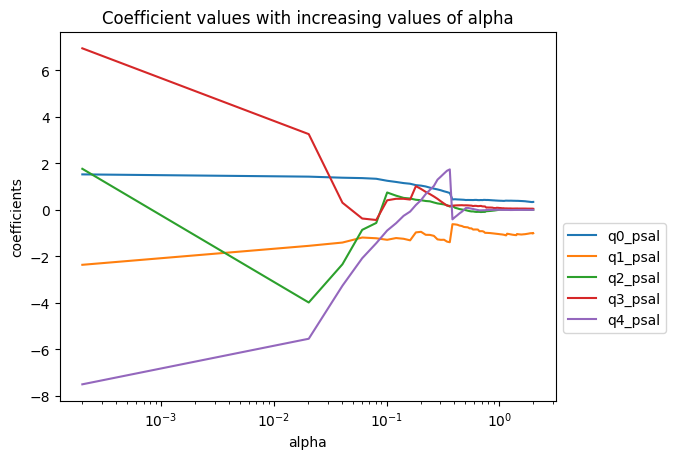

In [188]:
ax = plt.gca()
ax.plot(alphas*2, coefs_sal)
ax.set_xscale('log')
ax.legend(features[:5],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

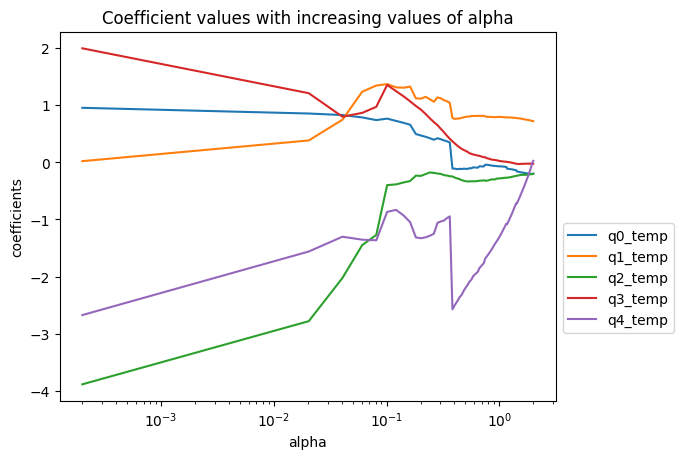

In [189]:
ax = plt.gca()
ax.plot(alphas*2, coefs_temp)
ax.set_xscale('log')
ax.legend(features[5:],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

## regression on unit

In [2]:
import pandas as pd

In [3]:
import warnings
warnings.simplefilter('ignore')

In [61]:
data = pd.read_csv('all_ocean_data.csv')
data.sort_values(by=['float_number'], ascending=[True])
data

,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
0,53553,1999-10-21,-12.29000,106.73400,34.287,34.5470,34.5380,34.6100,34.6440,27.071,7.836,4.707,3.303,2.309
1,53554,1999-10-22,-12.16700,111.88700,34.221,34.6200,34.5870,34.6660,34.7090,27.984,7.873,4.659,3.314,2.497
2,53555,1999-10-24,-13.21600,115.99200,34.172,34.5910,34.5920,34.6520,34.7140,28.460,8.153,4.996,3.522,2.494
3,53546,1999-10-25,-13.02900,119.97000,34.052,34.4360,34.4360,34.5010,34.5630,28.987,7.955,5.114,3.551,2.614
4,53553,1999-10-31,-12.58100,106.34700,34.127,34.5620,34.5470,34.6300,34.6700,27.646,7.971,5.326,3.438,2.518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681514,6902996,2024-09-17,-20.45890,-83.06815,35.136,34.4910,34.4970,34.5760,34.6330,17.813,7.365,4.396,2.943,2.214
681515,6903027,2024-09-17,61.49000,-55.76900,32.821,34.8890,34.8850,34.9030,34.9140,5.734,4.320,3.692,3.482,3.173
681516,6904068,2024-09-17,-56.63389,45.01372,33.878,34.6680,34.7360,34.7190,34.6960,0.214,1.908,1.584,1.091,0.704
681517,7900798,2024-09-17,-59.38800,-117.09500,33.941,34.2994,34.6058,34.7078,34.7236,3.180,2.847,2.393,2.025,1.572


In [62]:
floats = data['float_number'].unique()

In [66]:
all_data = pd.DataFrame()
for fl in floats:
    df = data[data['float_number'] == fl]
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=['date'],ascending=[True])
    df['day_difference'] = df['date'].diff().dt.days
    df['q0_psal_diff'] = 0
    df['q1_psal_diff'] = 0
    df['q2_psal_diff'] = 0
    df['q3_psal_diff'] = 0
    df['q4_psal_diff'] = 0
    df['q0_temp_diff'] = 0
    df['q1_temp_diff'] = 0
    df['q2_temp_diff'] = 0
    df['q3_temp_diff'] = 0
    df['q4_temp_diff'] = 0
    df['distance'] = 0
    index = df.index.tolist()
    if len(df)>1:
        for i in range(len(index)-1):
            curr_lat, curr_long = df['latitude'].loc[index[i]], df['longitude'].loc[index[i]]
            next_lat, next_long = df['latitude'].loc[index[i+1]], df['longitude'].loc[index[i+1]]
            df['distance'].loc[index[i+1]] = (((curr_lat-next_lat)**2)+((curr_long-next_long)**2))**0.5
            df['q0_psal_diff'].loc[index[i+1]] = df['q0_psal'].loc[index[i+1]] - df['q0_psal'].loc[index[i]]
            df['q1_psal_diff'].loc[index[i+1]] = df['q1_psal'].loc[index[i+1]] - df['q1_psal'].loc[index[i]]
            df['q2_psal_diff'].loc[index[i+1]] = df['q2_psal'].loc[index[i+1]] - df['q2_psal'].loc[index[i]]
            df['q3_psal_diff'].loc[index[i+1]] = df['q3_psal'].loc[index[i+1]] - df['q3_psal'].loc[index[i]]
            df['q4_psal_diff'].loc[index[i+1]] = df['q4_psal'].loc[index[i+1]] - df['q4_psal'].loc[index[i]]
            df['q0_temp_diff'].loc[index[i+1]] = df['q0_temp'].loc[index[i+1]] - df['q0_temp'].loc[index[i]]
            df['q1_temp_diff'].loc[index[i+1]] = df['q1_temp'].loc[index[i+1]] - df['q1_temp'].loc[index[i]]
            df['q2_temp_diff'].loc[index[i+1]] = df['q2_temp'].loc[index[i+1]] - df['q2_temp'].loc[index[i]]
            df['q3_temp_diff'].loc[index[i+1]] = df['q3_temp'].loc[index[i+1]] - df['q3_temp'].loc[index[i]]
            df['q4_temp_diff'].loc[index[i+1]] = df['q4_temp'].loc[index[i+1]] - df['q4_temp'].loc[index[i]]
        df['flow_rate'] = df['distance']*10/df['day_difference']
        df.dropna(inplace=True)
    if all_data.empty:
        all_data = df
    else:
        all_data = pd.concat([all_data,df])

In [67]:
all_data.to_csv('regression_data_01.csv',index=False)

In [69]:
data = pd.read_csv('regression_data_01.csv')

In [70]:
len(data)

668441

In [71]:
data.isna().sum()

float_number         0
date                 0
latitude             0
longitude            0
q0_psal              0
q1_psal              0
q2_psal              0
q3_psal              0
q4_psal              0
q0_temp              0
q1_temp              0
q2_temp              0
q3_temp              0
q4_temp              0
day_difference     505
q0_psal_diff      2848
q1_psal_diff      2848
q2_psal_diff      2848
q3_psal_diff      2848
q4_psal_diff      2848
q0_temp_diff      2848
q1_temp_diff      2848
q2_temp_diff      2848
q3_temp_diff      2848
q4_temp_diff      2848
distance             0
flow_rate          505
dtype: int64

In [72]:
data = data[data['day_difference']>1]

In [73]:
len(data)

661442

In [74]:
#data.dropna(inplace=True)

In [75]:
floats = data['float_number'].unique()

In [76]:
X = data[['q0_psal_diff',
    'q1_psal_diff',
    'q2_psal_diff',
    'q3_psal_diff',
    'q4_psal_diff',
    'q0_temp_diff',
    'q1_temp_diff',
    'q2_temp_diff',
    'q3_temp_diff',
    'q4_temp_diff']]
y = data['distance']

In [77]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2) 

In [78]:
for i in train_X, test_X, train_y, test_y:
    print(i.shape)

(529153, 10)
(132289, 10)
(529153,)
(132289,)


In [79]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for X and fit on train_X
scaler_X = StandardScaler()
train_X = scaler_X.fit_transform(train_X)

# Use the same scaler to transform test_X
test_X = scaler_X.transform(test_X)


In [80]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.0001, max_iter=100, tol=0.1)
model.fit(train_X, train_y) 

Lasso(alpha=0.0001, max_iter=100, tol=0.1)

In [81]:
features = X.columns

In [82]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.00001, 0.01, 100)
coefs_sal = []
coefs_temp = []

# Loop over alpha values
for a in alphas:
    model.set_params(alpha=a)
    

    # Fit the model
    model.fit(train_X, train_y)
    
    # Append the relevant coefficients for salinity and temperature
    coefs_sal.append(model.coef_[:5])
    coefs_temp.append(model.coef_[5:])
    

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

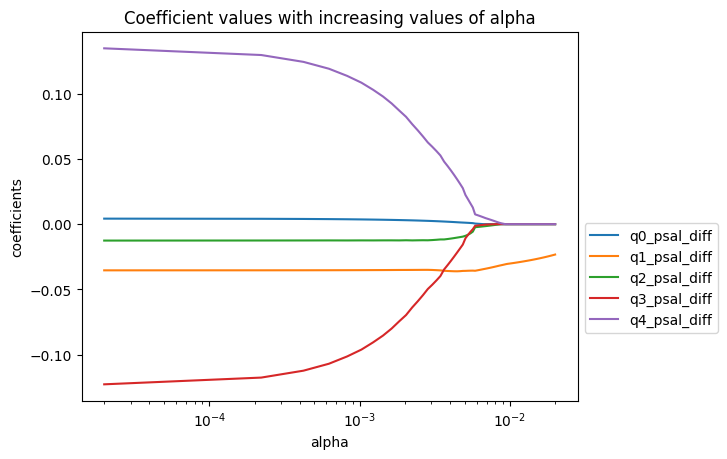

In [83]:
ax = plt.gca()
ax.plot(alphas*2, coefs_sal)
ax.set_xscale('log')
ax.legend(features[:5],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

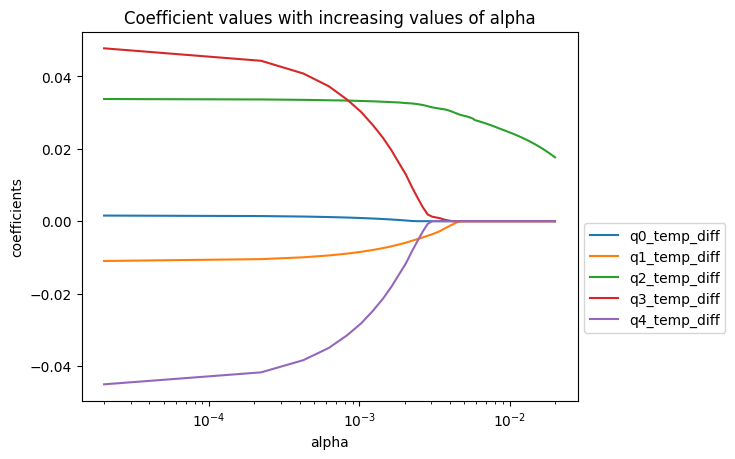

In [84]:
ax = plt.gca()
ax.plot(alphas*2, coefs_temp)
ax.set_xscale('log')
ax.legend(features[5:],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

In [ ]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.0001, 1, 100)
coefs_sal = []
coefs_temp = []

# Loop over alpha values
for a in alphas:
    model.set_params(alpha=a)
    
    # Lists to store coefficients for each float at a given alpha
    avg_sal = []
    avg_temp = []
    
    # Loop over each float value
    for fl in floats:
        # Subset data for the given float value
        df = data[data['float_number'] == fl]
        X = df.drop(['flow_rate', 'date', 'float_number', 'latitude', 'longitude', 'day_difference', 'distance'], axis=1)
        X = scaler_X.transform(X)
        y = df['flow_rate']
        
        # Fit the model
        model.fit(X, y)
        
        # Append the relevant coefficients for salinity and temperature
        avg_sal.append(model.coef_[:5])
        avg_temp.append(model.coef_[5:])
    
    # Compute the average of the coefficients for each float at this alpha
    mean_sal = np.mean(avg_sal, axis=0)
    mean_temp = np.mean(avg_temp, axis=0)
    
    # Store the averaged coefficients for this alpha
    coefs_sal.append(mean_sal)
    coefs_temp.append(mean_temp)

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

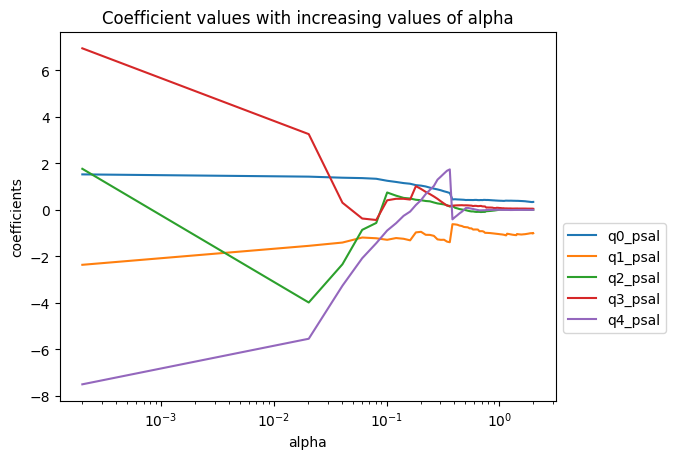

In [ ]:
ax = plt.gca()
ax.plot(alphas*2, coefs_sal)
ax.set_xscale('log')
ax.legend(features[:5],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

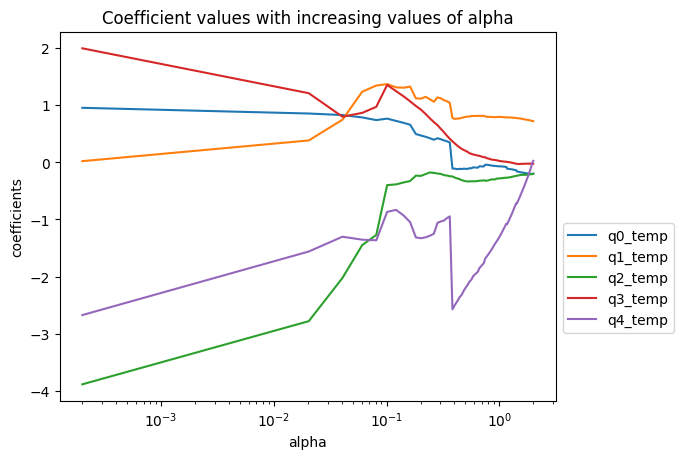

In [ ]:
ax = plt.gca()
ax.plot(alphas*2, coefs_temp)
ax.set_xscale('log')
ax.legend(features[5:],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

## Regression on unit/10days

In [38]:
import pandas as pd

In [39]:
import warnings
warnings.simplefilter('ignore')

In [40]:
data = pd.read_csv('all_ocean_data.csv')
data.sort_values(by=['float_number'], ascending=[True])
data

,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
0,53553,1999-10-21,-12.29000,106.73400,34.287,34.5470,34.5380,34.6100,34.6440,27.071,7.836,4.707,3.303,2.309
1,53554,1999-10-22,-12.16700,111.88700,34.221,34.6200,34.5870,34.6660,34.7090,27.984,7.873,4.659,3.314,2.497
2,53555,1999-10-24,-13.21600,115.99200,34.172,34.5910,34.5920,34.6520,34.7140,28.460,8.153,4.996,3.522,2.494
3,53546,1999-10-25,-13.02900,119.97000,34.052,34.4360,34.4360,34.5010,34.5630,28.987,7.955,5.114,3.551,2.614
4,53553,1999-10-31,-12.58100,106.34700,34.127,34.5620,34.5470,34.6300,34.6700,27.646,7.971,5.326,3.438,2.518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681514,6902996,2024-09-17,-20.45890,-83.06815,35.136,34.4910,34.4970,34.5760,34.6330,17.813,7.365,4.396,2.943,2.214
681515,6903027,2024-09-17,61.49000,-55.76900,32.821,34.8890,34.8850,34.9030,34.9140,5.734,4.320,3.692,3.482,3.173
681516,6904068,2024-09-17,-56.63389,45.01372,33.878,34.6680,34.7360,34.7190,34.6960,0.214,1.908,1.584,1.091,0.704
681517,7900798,2024-09-17,-59.38800,-117.09500,33.941,34.2994,34.6058,34.7078,34.7236,3.180,2.847,2.393,2.025,1.572


In [41]:
floats = data['float_number'].unique()

In [42]:
all_data = pd.DataFrame()
for fl in floats:
    df = data[data['float_number'] == fl]
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=['date'],ascending=[True])
    df['day_difference'] = df['date'].diff().dt.days
    df['q0_psal_diff'] = 0
    df['q1_psal_diff'] = 0
    df['q2_psal_diff'] = 0
    df['q3_psal_diff'] = 0
    df['q4_psal_diff'] = 0
    df['q0_temp_diff'] = 0
    df['q1_temp_diff'] = 0
    df['q2_temp_diff'] = 0
    df['q3_temp_diff'] = 0
    df['q4_temp_diff'] = 0
    df['distance'] = 0
    index = df.index.tolist()
    if len(df)>1:
        for i in range(len(index)-1):
            curr_lat, curr_long = df['latitude'].loc[index[i]], df['longitude'].loc[index[i]]
            next_lat, next_long = df['latitude'].loc[index[i+1]], df['longitude'].loc[index[i+1]]
            df['distance'].loc[index[i+1]] = (((curr_lat-next_lat)**2)+((curr_long-next_long)**2))**0.5
            day_diff = df['day_difference'].loc[index[i+1]]
            df['q0_psal_diff'].loc[index[i+1]] = (df['q0_psal'].loc[index[i+1]] - df['q0_psal'].loc[index[i]])*10/day_diff
            df['q1_psal_diff'].loc[index[i+1]] = (df['q1_psal'].loc[index[i+1]] - df['q1_psal'].loc[index[i]])*10/day_diff
            df['q2_psal_diff'].loc[index[i+1]] = (df['q2_psal'].loc[index[i+1]] - df['q2_psal'].loc[index[i]])*10/day_diff
            df['q3_psal_diff'].loc[index[i+1]] = (df['q3_psal'].loc[index[i+1]] - df['q3_psal'].loc[index[i]])*10/day_diff
            df['q4_psal_diff'].loc[index[i+1]] = (df['q4_psal'].loc[index[i+1]] - df['q4_psal'].loc[index[i]])*10/day_diff
            df['q0_temp_diff'].loc[index[i+1]] = (df['q0_temp'].loc[index[i+1]] - df['q0_temp'].loc[index[i]])*10/day_diff
            df['q1_temp_diff'].loc[index[i+1]] = (df['q1_temp'].loc[index[i+1]] - df['q1_temp'].loc[index[i]])*10/day_diff
            df['q2_temp_diff'].loc[index[i+1]] = (df['q2_temp'].loc[index[i+1]] - df['q2_temp'].loc[index[i]])*10/day_diff
            df['q3_temp_diff'].loc[index[i+1]] = (df['q3_temp'].loc[index[i+1]] - df['q3_temp'].loc[index[i]])*10/day_diff
            df['q4_temp_diff'].loc[index[i+1]] = (df['q4_temp'].loc[index[i+1]] - df['q4_temp'].loc[index[i]])*10/day_diff
        df['flow_rate'] = df['distance']*10/df['day_difference']
        df.dropna(inplace=True)
    if all_data.empty:
        all_data = df
    else:
        all_data = pd.concat([all_data,df])

In [43]:
all_data.to_csv('regression_data_02.csv',index=False)

In [52]:
data = pd.read_csv('regression_data_02.csv')

In [53]:
data.duplicated().sum()

0

In [54]:
data.isna().sum()

float_number        0
date                0
latitude            0
longitude           0
q0_psal             0
q1_psal             0
q2_psal             0
q3_psal             0
q4_psal             0
q0_temp             0
q1_temp             0
q2_temp             0
q3_temp             0
q4_temp             0
day_difference    505
q0_psal_diff        0
q1_psal_diff        0
q2_psal_diff        0
q3_psal_diff        0
q4_psal_diff        0
q0_temp_diff        0
q1_temp_diff        0
q2_temp_diff        0
q3_temp_diff        0
q4_temp_diff        0
distance            0
flow_rate         505
dtype: int64

In [55]:
len(data)

668441

In [56]:
data = data[data['day_difference']>1]

In [57]:
len(data)

661442

In [58]:
#data.dropna(inplace=True)

In [59]:
floats = data['float_number'].unique()

In [60]:
X = data[['q0_psal_diff',
    'q1_psal_diff',
    'q2_psal_diff',
    'q3_psal_diff',
    'q4_psal_diff',
    'q0_temp_diff',
    'q1_temp_diff',
    'q2_temp_diff',
    'q3_temp_diff',
    'q4_temp_diff']]
y = data['flow_rate']

In [61]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2) 

In [62]:
for i in train_X, test_X, train_y, test_y:
    print(i.shape)

(529153, 10)
(132289, 10)
(529153,)
(132289,)


In [63]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for X and fit on train_X
scaler_X = StandardScaler()
train_X = scaler_X.fit_transform(train_X)

# Use the same scaler to transform test_X
test_X = scaler_X.transform(test_X)


In [64]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.0001, max_iter=100, tol=0.1)
model.fit(train_X, train_y) 

Lasso(alpha=0.0001, max_iter=100, tol=0.1)

In [65]:
features = X.columns

In [66]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.00001, 0.01, 100)
coefs_sal = []
coefs_temp = []

# Loop over alpha values
for a in alphas:
    model.set_params(alpha=a)
    

    # Fit the model
    model.fit(train_X, train_y)
    
    # Append the relevant coefficients for salinity and temperature
    coefs_sal.append(model.coef_[:5])
    coefs_temp.append(model.coef_[5:])
    

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

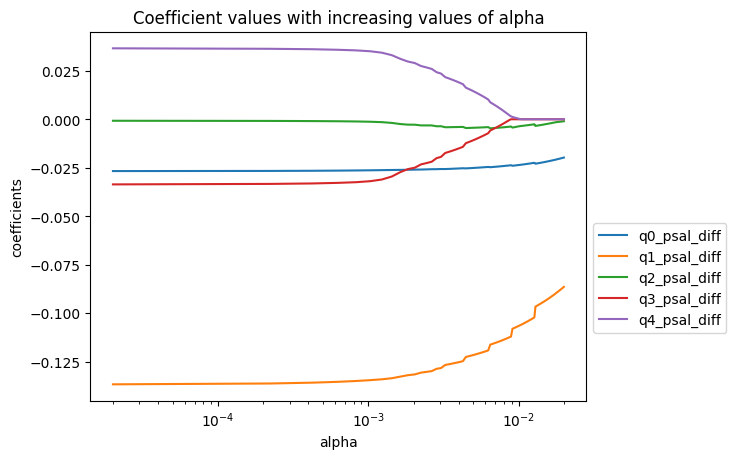

In [67]:
ax = plt.gca()
ax.plot(alphas*2, coefs_sal)
ax.set_xscale('log')
ax.legend(features[:5],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

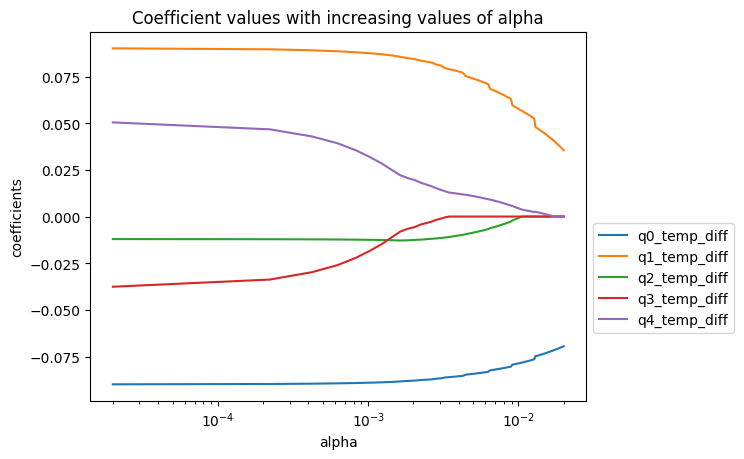

In [68]:
ax = plt.gca()
ax.plot(alphas*2, coefs_temp)
ax.set_xscale('log')
ax.legend(features[5:],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

In [ ]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.0001, 1, 100)
coefs_sal = []
coefs_temp = []

# Loop over alpha values
for a in alphas:
    model.set_params(alpha=a)
    
    # Lists to store coefficients for each float at a given alpha
    avg_sal = []
    avg_temp = []
    
    # Loop over each float value
    for fl in floats:
        # Subset data for the given float value
        df = data[data['float_number'] == fl]
        X = df.drop(['flow_rate', 'date', 'float_number', 'latitude', 'longitude', 'day_difference', 'distance'], axis=1)
        X = scaler_X.transform(X)
        y = df['flow_rate']
        
        # Fit the model
        model.fit(X, y)
        
        # Append the relevant coefficients for salinity and temperature
        avg_sal.append(model.coef_[:5])
        avg_temp.append(model.coef_[5:])
    
    # Compute the average of the coefficients for each float at this alpha
    mean_sal = np.mean(avg_sal, axis=0)
    mean_temp = np.mean(avg_temp, axis=0)
    
    # Store the averaged coefficients for this alpha
    coefs_sal.append(mean_sal)
    coefs_temp.append(mean_temp)

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

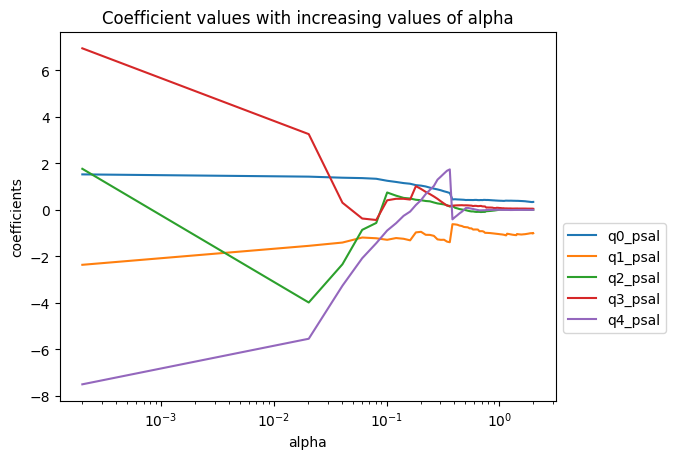

In [ ]:
ax = plt.gca()
ax.plot(alphas*2, coefs_sal)
ax.set_xscale('log')
ax.legend(features[:5],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

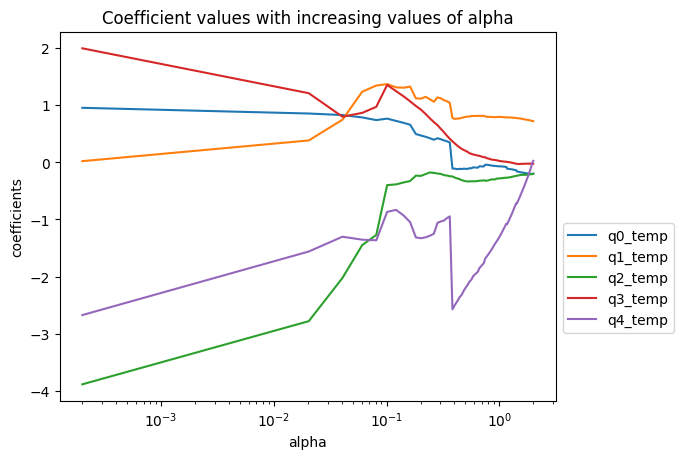

In [ ]:
ax = plt.gca()
ax.plot(alphas*2, coefs_temp)
ax.set_xscale('log')
ax.legend(features[5:],bbox_to_anchor=(1,0.5))
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

## Multicollinearity

In [63]:
%pip install statsmodels

  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB 777.7 kB/s eta 0:00:13
   - -------------------------------------- 0.3/9.9 MB 2.0 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/9.9 MB 3.5 MB/s eta 0:00:03
   ----- ---------------------------------- 1.4/9.9 MB 6.5 MB/s eta 0:00:02
   ------------- -------------------------- 3.3/9.9 MB 12.2 MB/s eta 0:00:01
   ------------------------ --------------- 6.1/9.9 MB 19.5 MB/s eta 0:00:01
   ------------------------------- -------- 7.8/9.9 MB 23.8 MB/s eta 0:00:01
   ----------------------------------- ---- 8.8/9.9 MB 22.4 MB/s eta 0:00:01
   ------------------------------------- -- 9.3/9.9 MB 22.1 MB/s eta 0:00:01
   ------------------------------------- -- 9.3/9.9 MB 22.1 MB/s eta 0:00:01
   -------------------------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import statsmodels as sm
 
def get_vdp_matrix(dataset):
    columns = dataset.columns
    np_vdp = dataset.to_numpy()
    _len = np.sqrt(np.sum(np_vdp**2, axis=0))
    np_vdp = np_vdp/_len
    eig_mat = np_vdp.T.dot(np_vdp)
    egval, egvec = np.linalg.eigh(eig_mat)
    idx = egval.argsort()[::-1]
    egval = egval[idx]
    egvec = egvec[:,idx]
    condition_index = (egval.max()/ egval)**0.5
    k = len(egval)
    vdp = np.empty((k,k))
 
    for i in range(k):
        phi = (egvec[i]**2)/egval
        vdp[i] = (phi/sum(phi))
    vdp_df = pd.DataFrame(vdp.T, columns=columns)
    vdp_df.insert(0, "condition_index", condition_index, True)
    vdp_df.insert(0,"EigenValues", egval, True)
    indices = vdp_df[vdp_df['condition_index']>9]['condition_index'].index
    if len(indices)>1:
        for index in indices:
            row = vdp_df.loc[index].drop(['EigenValues', 'condition_index'])
            print("Condition_index of ", index, " = ", vdp_df.loc[index]['condition_index'], '\n',  row[row>0.75])
    elif len(indices) == 1:
        row = vdp_df.loc[indices[0]].drop(['EigenValues', 'condition_index'])
        print("Condition_index of ", indices[0], " = ", vdp_df.loc[indices[0]]['condition_index'], '\n',  row[row>0.75])
 
    plt.figure(figsize=(20,20))
    #plot heat map
    black_yellow_cmap = LinearSegmentedColormap.from_list('black_yellow', ['black', '#FCC116'])
    g=sns.heatmap(round(vdp_df, 2),annot=True,cmap=black_yellow_cmap, vmin=0, vmax=1)
    return vdp_df

In [95]:
data = pd.read_csv('all_ocean_data.csv')

In [97]:
data.drop(['Unnamed: 0','float_number','date'], axis=1, inplace=True)

Condition_index of  5  =  13.43753888756293 
 Series([], Name: 5, dtype: float64)
Condition_index of  6  =  21.151882983373802 
 Series([], Name: 6, dtype: float64)
Condition_index of  7  =  50.80902874713809 
 Series([], Name: 7, dtype: float64)
Condition_index of  8  =  161.12469326928206 
 q0_psal    0.938964
Name: 8, dtype: float64
Condition_index of  9  =  551.4066389536606 
 Series([], Name: 9, dtype: float64)
Condition_index of  10  =  1308.7433733838445 
 Series([], Name: 10, dtype: float64)
Condition_index of  11  =  4132.360534272956 
 q3_psal    0.997193
q4_psal    0.903649
Name: 11, dtype: float64


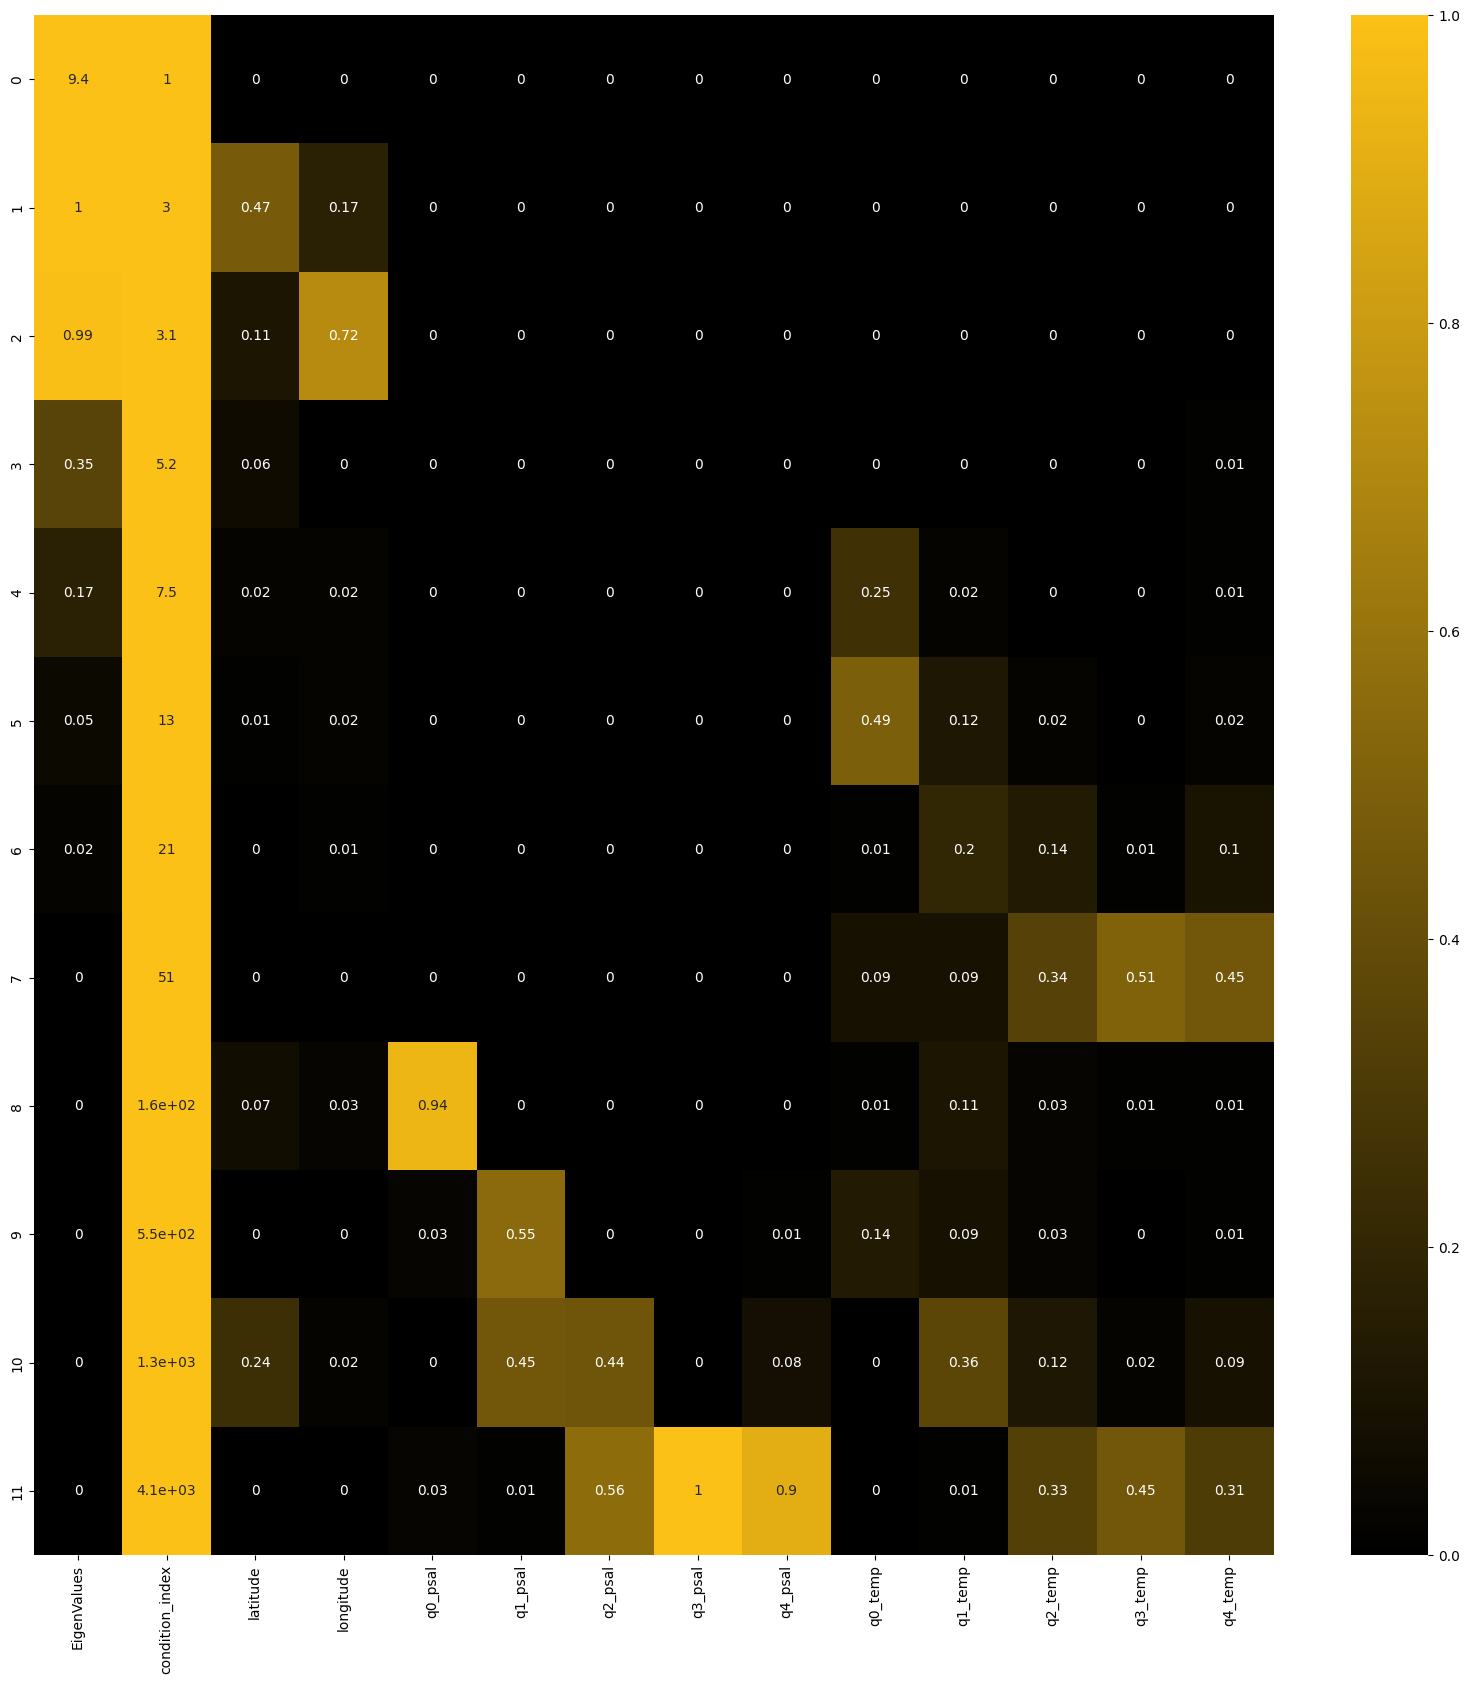

In [98]:
df = get_vdp_matrix(data)

In [51]:
data.corr()>0.8

,LongitudePredictions,LongitudeActuals,LatitudePredictions,LatitudeActuals,residual,neg_res
LongitudePredictions,True,True,False,False,False,False
LongitudeActuals,True,True,False,False,False,False
LatitudePredictions,False,False,True,True,False,False
LatitudeActuals,False,False,True,True,False,False
residual,False,False,False,False,True,False
neg_res,False,False,False,False,False,True


In [52]:
data.corr()

,LongitudePredictions,LongitudeActuals,LatitudePredictions,LatitudeActuals,residual,neg_res
LongitudePredictions,1.000000,0.999871,-0.045683,-0.040085,0.058617,-0.058617
LongitudeActuals,0.999871,1.000000,-0.040830,-0.035252,0.052847,-0.052847
LatitudePredictions,-0.045683,-0.040830,1.000000,0.999021,-0.199879,0.199879
LatitudeActuals,-0.040085,-0.035252,0.999021,1.000000,-0.218028,0.218028
residual,0.058617,0.052847,-0.199879,-0.218028,1.000000,-1.000000
neg_res,-0.058617,-0.052847,0.199879,0.218028,-1.000000,1.000000


In [66]:
data = np.random.rand(100,10)

df = pd.DataFrame(data, columns=['Column {}'.format(i) for i in range(1,11)])

df['sum'] = df.sum(axis=1)

In [67]:
df

,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,Column 10,sum
0,0.489729,0.853090,0.333073,0.028751,0.529018,0.721215,0.255842,0.908091,0.661306,0.573446,5.353559
1,0.179325,0.397071,0.084686,0.464148,0.082795,0.985624,0.797565,0.175817,0.610345,0.011418,3.788794
2,0.648242,0.245001,0.845859,0.768699,0.296308,0.622982,0.195084,0.106863,0.577205,0.632240,4.938483
3,0.645930,0.862595,0.261675,0.720480,0.473878,0.720842,0.762784,0.607326,0.115263,0.073718,5.244491
4,0.459835,0.201645,0.294161,0.309354,0.410152,0.244817,0.810420,0.356808,0.342881,0.380633,3.810706
...,...,...,...,...,...,...,...,...,...,...,...
95,0.682781,0.338283,0.683599,0.135131,0.799163,0.965720,0.262792,0.099387,0.051958,0.352692,4.371505
96,0.958906,0.261889,0.964067,0.542078,0.515726,0.296802,0.974794,0.425666,0.698576,0.799459,6.437963
97,0.319360,0.755651,0.465844,0.040828,0.491542,0.798714,0.964838,0.446221,0.338595,0.219154,4.840746
98,0.167176,0.518223,0.432003,0.130452,0.150449,0.759267,0.808772,0.589694,0.224717,0.463862,4.244617


In [68]:
df.corr()['sum']

Column 1     0.365046
Column 2     0.116356
Column 3     0.311391
Column 4     0.254911
Column 5     0.347748
Column 6     0.055394
Column 7     0.286684
Column 8     0.336555
Column 9     0.445026
Column 10    0.233965
sum          1.000000
Name: sum, dtype: float64

Condition_index of  10  =  170531083.35837993 
 Column 1     1.0
Column 2     1.0
Column 3     1.0
Column 4     1.0
Column 5     1.0
Column 6     1.0
Column 7     1.0
Column 8     1.0
Column 9     1.0
Column 10    1.0
sum          1.0
Name: 10, dtype: float64


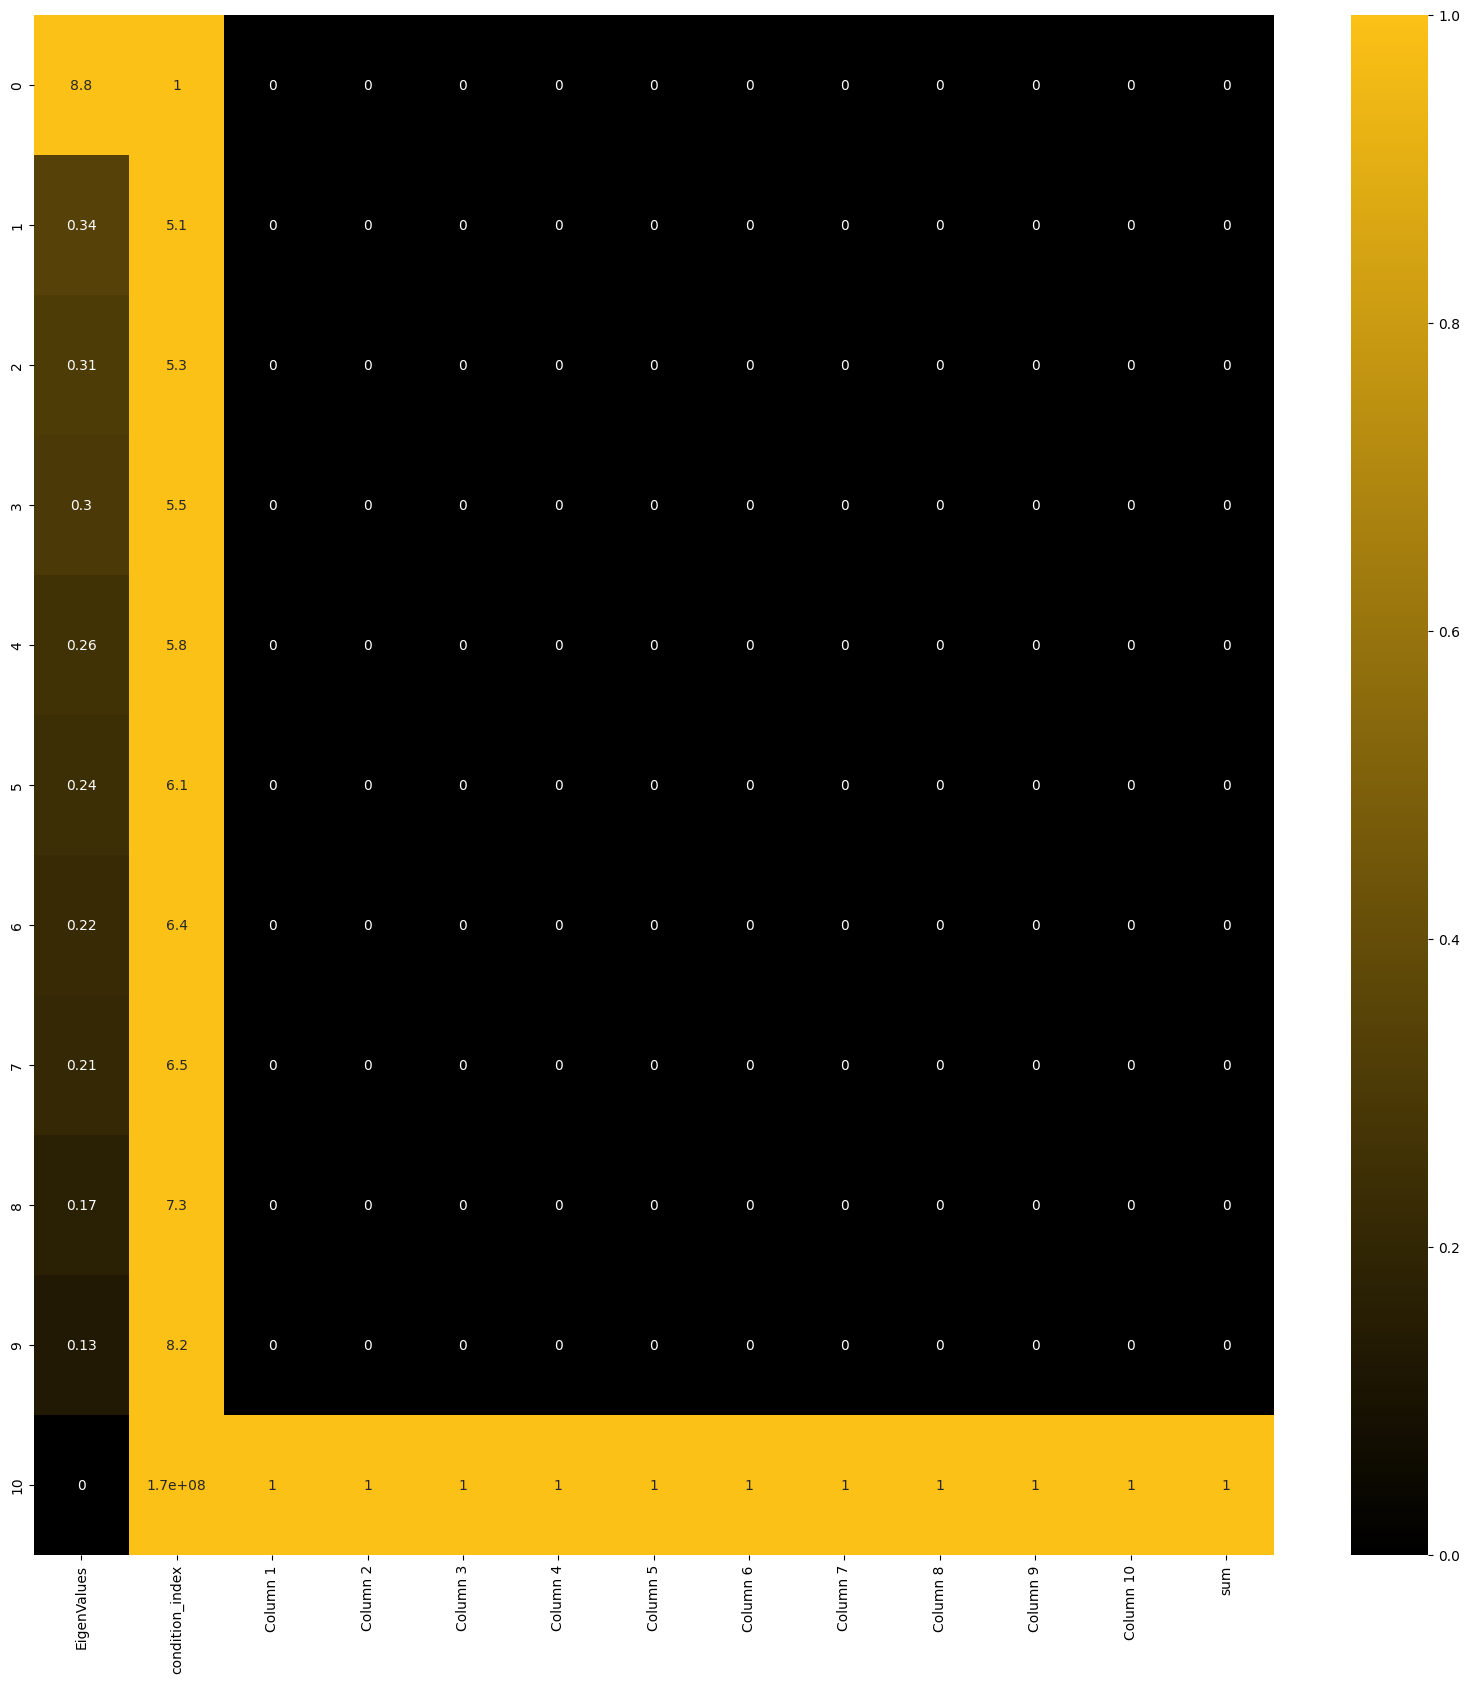

In [69]:
vdp = get_vdp_matrix(df)